# Fitting with spectral-cube and astropy #

## Authors ##
Eric Koch, (add here)

## Learning Goals ##

* Fitting 1D models to spectra in a spectral-line data cube
* Fitting 2D models to spectral channels or 2D projections
* Enabling dask mode for large data cubes

## Keywords ##

radio astronomy, spectral-line data cubes, spectral fitting, spatial fitting

## Summary ##

This tutorial demonstrates methods to fit models to a spectral-cube object using [astropy.modeling](https://docs.astropy.org/en/stable/modeling/).

## Requires ##

```
pip install astropy
pip install spectral-cube
pip install radio-beam
pip install dask
pip install aplpy
```


In [6]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from spectral_cube import SpectralCube, Projection
import astropy.units as u
from astropy.io import fits
from astropy.modeling import models, fitting
from astropy.convolution import convolve_models


Fitting models to both spatial maps and spectra are amongst the most common operations involving spectral-line data cubes.

In this tutorial, we explore how to fit models to a `SpectralCube` using `astropy.modeling`. To show this, we will use an ALMA mosaic observed with the ACA, or 7-m array. This mosaic is one component of an ALMA project to map CO(2-1) in M33 (Project ID 2019.1.01182.S).

To keep the data volume small, we will use a 10 MB cutout of the full mosaic for this tutorial.

In [1]:
from astropy.utils.data import download_file

datafile = download_file(
    'https://zenodo.org/record/4021108/files/M33_Brick1Tile1_12CO21_0p7kms.image.pbcor_K.cutout.fits',
    cache=True, show_progress=True)

# Note that the datafile will not end in ".fits". Because of that, we need to specify the format
# When the file name end in "fits", `format` will not need to be specified 
cube = SpectralCube.read(datafile, format='fits')

The basic cube properties are:

In [2]:
cube

SpectralCube with shape=(300, 64, 64) and unit=K:
 n_x:     64  type_x: RA---SIN  unit_x: deg    range:    23.408277 deg:   23.428647 deg
 n_y:     64  type_y: DEC--SIN  unit_y: deg    range:    30.750561 deg:   30.768065 deg
 n_s:    300  type_s: VRAD      unit_s: m / s  range:  -280000.000 m / s:  -79670.000 m / s

Note that the spectral unit is in m/s from the FITS file. It will be convenient to instead use km/s, so we will convert the cube's spectral unit:

In [3]:
cube = cube.with_spectral_unit(u.km / u.s)

## Fitting a 1D spectral model ##

This part demonstrates how 1D spectra can be fit from a `SpectralCube`. This spectral-line data cube is of CO(2-1) emission that primarily arises from giant molecular clouds (GMCs). In GMCs, we expect the CO(2-1) line shape to be set by random turbulent motions that produces a Gaussian line shape when observed on $\sim40$ pc, like for these observations. Spectra can also be a combination of Gaussian line profiles if multiple sources are detected along a line-of-sight.

Here, we will extract a single spectrum with bright CO emission for this example. The pixel (y, x) = (145, 340) is a location with bright CO emission.

We can extract this one spectrum from the cube and plot it:

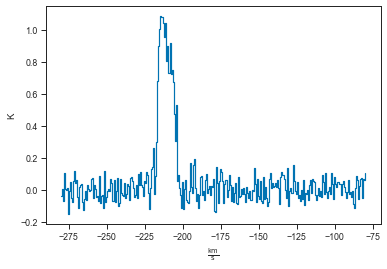

In [4]:
# One example to test this on to start
# y, x = 145, 340
y, x = 32, 32

spec = cube[:, y, x]
spec.quicklook()

This spectrum has a reasonably high signal-to-noise ratio and should provide a good example for spectral fitting. Note that spectra with a low peak signal-to-noise may require restrictions on the parameter space for the fit to converge.

Based on the above spectrum, we can provide good initial parameter values to start the fit with.

In [7]:
# The 1D Gaussian model with initial guesses for parameters
g_init = models.Gaussian1D(amplitude=1.0 * u.K, mean=-210 * u.km / u.s, stddev=4. * u.km / u.s)

# And fit with the Levenberg-Marquardt algorithm and least squares statistic.
fit_g = fitting.LevMarLSQFitter()

# The initial model, spectral axis (in km/s) and spectrum are passed for the fit
g_fit = fit_g(g_init, spec.spectral_axis, spec)

The fit model parameters are:

In [8]:
g_fit

<Gaussian1D(amplitude=1.09745703 K, mean=-211.55635877 km / s, stddev=4.18782779 km / s)>

These parameters all seem reasonable given the plotted spectrum above. To compare more closely, we can plot the spectrum and the fit model:

Text(0.5, 0, 'Radio Velocity (km /s)')

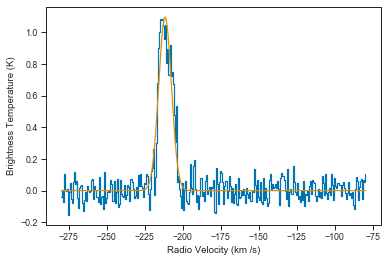

In [9]:
spec.quicklook()
plt.plot(spec.spectral_axis, g_fit(spec.spectral_axis))
plt.ylabel("Brightness Temperature (K)")
plt.xlabel("Radio Velocity (km /s)")

And the fit residuals:

Text(0.5, 0, 'Radio Velocity (km /s)')

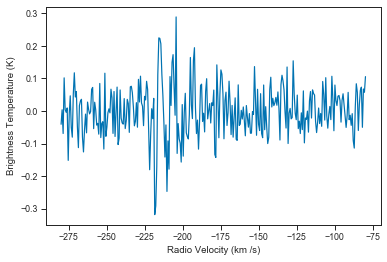

In [10]:
plt.plot(spec.spectral_axis, spec - g_fit(spec.spectral_axis))
plt.ylabel("Brightness Temperature (K)")
plt.xlabel("Radio Velocity (km /s)")

Some residuals remain, however, the fit is fairly good.

One major feature of `astropy.modeling.models` is the built-in handling of units. The fitted model `g_fit` already has each parameter in useful physical units.

### Exercise ###

Can the above be example fit be improved with a more sophisticated model? Try the fit using multiple Gaussian components.

### Using dask ###

When using a large spectral-line data cube, the [dask](https://dask.org/) library can be used in spectral-cube for operations instead of numpy. See the [spectral-cube documentation](https://spectral-cube.readthedocs.io/en/latest/dask.html) on dask integration for a thorough description.

Most of the above code for fitting a spectrum will be unchanged. What will change is how the data cube is read in:

In [11]:
cube = SpectralCube.read(datafile, use_dask=True, format='fits')
cube = cube.with_spectral_unit(u.km / u.s)

cube.use_dask_scheduler('synchronous')

from dask.diagnostics import ProgressBar

pbar = ProgressBar()
pbar.register()

Using dask is enabled with `use_dask=True` and the remainder of the code (i) sets using synchronous (serial) operations and (ii) enables printing a progress bar when dask is performing an operation.

Now when we look at the cube properties:

In [12]:
cube

DaskSpectralCube with shape=(300, 64, 64) and unit=K and chunk size (300, 64, 64):
 n_x:     64  type_x: RA---SIN  unit_x: deg    range:    23.408277 deg:   23.428647 deg
 n_y:     64  type_y: DEC--SIN  unit_y: deg    range:    30.750561 deg:   30.768065 deg
 n_s:    300  type_s: VRAD      unit_s: km / s  range:     -280.000 km / s:     -79.670 km / s

we see that this is a [DaskSpectralCube](https://spectral-cube.readthedocs.io/en/latest/api/spectral_cube.DaskSpectralCube.html#spectral_cube.DaskSpectralCube) along with additional information. Dask will load the data in chunks, and the size of the chunks for this data cube are shown as the `chunk size`.

Fitting with the `DaskSpectralCube` looks similar to the example above:

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s


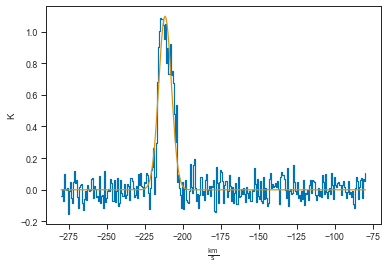

In [13]:
spec = cube[:, y, x]

# The 1D Gaussian model with initial guesses for parameters
g_init = models.Gaussian1D(amplitude=1.0 * u.K, mean=-210 * u.km / u.s, stddev=4. * u.km / u.s)

# And fit with the Levenberg-Marquardt algorithm and least squares statistic.
fit_g = fitting.LevMarLSQFitter()

# The initial model, spectral axis (in km/s) and spectrum are passed for the fit
g_fit = fit_g(g_init, spec.spectral_axis, spec)

spec.quicklook()
plt.plot(spec.spectral_axis, g_fit(spec.spectral_axis))

The result is identical, but we now see multiple progress bars printed. The bar is shown each time dask reads in or performs an operation. In this case, we're seeing dask read in the "chunk" of data that contains the spectrum we're fitting.

Using dask in this case is meant to be a working demonstration. The true value of using `DaskSpectralCube` is when many spectra in the cube require fitting. Dask allows for two features here: (i) parallelize fitting spectra to speed up the operation, and (ii) reading in the data in chunks to avoid excessive memory usage, which is critical when working with data cubes larger than your machine's memory. See the [ADD LINK TO PARALLEL FITTING TUTORIAL]() on fitting all spectra in a cube using `DaskSpectralCube`.

## Fitting a 2D spatial model ##

Using the same CO data, we will next cover how to fit a 2D Gaussian to a source and a simplistic approach to identify peaks. To show this, we will make a 2D velocity-integrated CO intensity map, or the moment 0 map. See [ADD LINK TO MOMENTS TUTORIAL]() on moment maps and how to make them.

For this example, we will focus on the same giant molecular cloud (GMC) as the 1D spectrum above.

To make an optimal moment 0 map, we should mask noisy regions of the data to highlight the signal. Here we will use a simple minimum threshold and integrate over the velocities corresponding to the signal in the 1D spectrum above ($\sim-230$ to $-200$ km/s):


In [14]:
# Mask noisy values
masked_cube = cube.with_mask(cube > 0.12 * u.K)

# Only integrate over channels with signal
masked_cube_slab = masked_cube.spectral_slab(-230 * u.km / u.s, -190 * u.km / u.s)

moment0 = masked_cube_slab.moment0()

[########################################] | 100% Completed |  0.1s


These sources are giant molecular clouds (GMCs) that appear "blob-like" at this resolution. A 2D Gaussian should be a reasonable model for each GMC. Note that this shape is primarily the "beam," the resolution element for these observations taken with the ALMA's (Morita) Compact Array.

For this example, we will focus on fitting a model to a single GMC; the same GMC where we fit the 1D spectrum above. To fit the model, we will slice out a small regions centered on the cloud:

INFO: Auto-setting vmin to -1.215e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.446e+01 [aplpy.core]


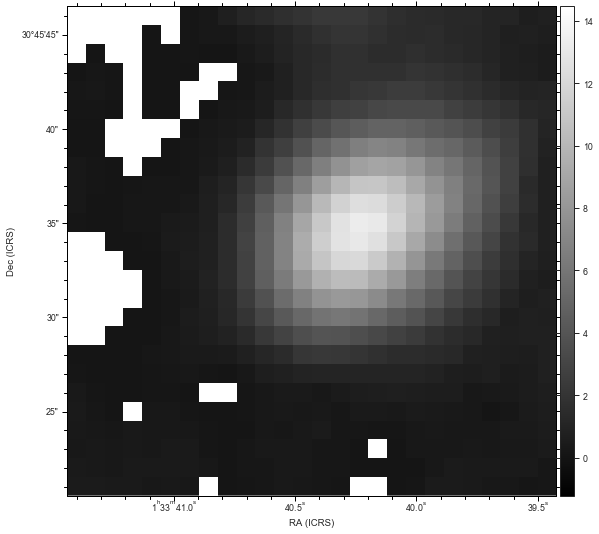

In [15]:
y, x = 32, 32
size = 13

moment0_cutout = moment0[y-size:y+size, x-size:x+size]
moment0_cutout.quicklook(use_aplpy=True)

Most of the map is a single GMC ("blob") with some emission from a neighbouring GMC at the north edge. This cut-out should be well-suited to fit a 2D Gaussian to.

The model to fit is defined below. To help the fit converge to the expected values, we will approximate the starting parameter values based on the image above.

We can also fit directly to the RA, Dec values since the modeling handles the units (and we're looking at a very small area so the sky curvature does not matter in this case). The Dec and RA values are returned for each pixel using `spatial_coordinate_map` (in order of Dec then RA).

In [17]:
# Define the spatial grid for the fit centered at y, x = 145, 342
yy, xx = moment0_cutout.spatial_coordinate_map

# Define a single 2D Gaussian model.
p_init_gauss2D = models.Gaussian2D(x_mean=xx[size, size], y_mean=yy[size, size],
                                   amplitude=12 * u.K * u.km / u.s,
                                   x_stddev=8 * u.arcsec, y_stddev=8 * u.arcsec)


# And fit with the Levenberg-Marquardt algorithm and least squares statistic.
fit_p = fitting.LevMarLSQFitter()

# TODO: should be able to use with_fill_value for projections
# fill value is NOT working for Projection.
# See https://github.com/radio-astro-tools/spectral-cube/pull/661
# mom0_sub.with_fill_value(fill_value=0.0).filled_data[:]

# Set NaNs to 0 for the fit.
moment0_cutout_quant = moment0_cutout.quantity
# moment0_cutout_quant = moment0_cutout.value
moment0_cutout_quant[np.isnan(moment0_cutout_quant)] = 0.

with warnings.catch_warnings():
    # Ignore model linearity warning from the fitter
    warnings.simplefilter('ignore')
    p_gauss2D = fit_p(p_init_gauss2D, xx, yy, moment0_cutout_quant)


The fitted model is:

In [18]:
p_gauss2D

<Gaussian2D(amplitude=12.87132516 K km / s, x_mean=23.41749457 deg, y_mean=30.75970478 deg, x_stddev=0.00136876 deg, y_stddev=0.00100932 deg, theta=-0.46608039 rad)>

This corresponds to a spatial size of:

In [19]:
print(f"{p_gauss2D.x_stddev.quantity.to(u.arcsec)} by {p_gauss2D.y_stddev.quantity.to(u.arcsec)}")

4.927549702771874 arcsec by 3.6335649764546365 arcsec


The parameters are similar to the cutout image shown above: the peak is about 12 K km/s and the centre of the GMC is near the centre of the cutout.

To visualize the quality of the fit, we can compare the data, model, and residuals:

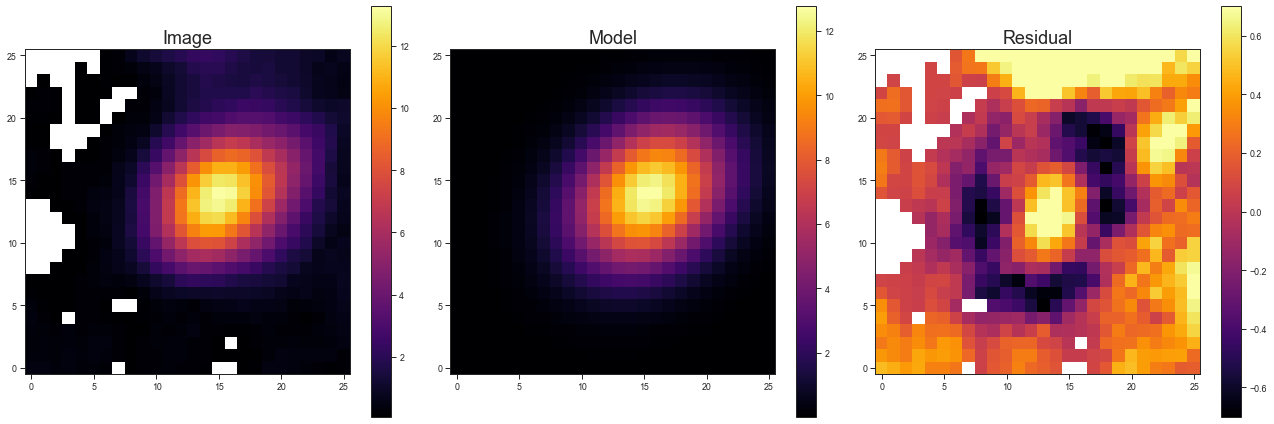

In [21]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.title("Image", fontsize=18)
plt.imshow(moment0_cutout.value, origin='lower', cmap='inferno')
plt.colorbar()
plt.subplot(1, 3, 2)
plt.title("Model", fontsize=18)
plt.imshow(p_gauss2D(xx, yy).value, origin='lower', cmap='inferno')
plt.colorbar()
plt.subplot(1, 3, 3)
plt.title("Residual", fontsize=18)
plt.imshow(moment0_cutout.value - p_gauss2D(xx, yy).value, origin='lower', cmap='inferno', vmin=-0.7, vmax=0.7)
plt.colorbar()

plt.tight_layout()

The fit agrees fairly well with the data, with the largest residuals coming from the edge of the map where another GMC is located.

This example shows the simplest approach to fitting a 2D model based on a 2D spatial projection. A more sophisticated approach would take the telescope beam into account, as in this case, the beam accounts for most of the size we recover. This should be possible by using the [astropy.convolution.convolve_models](https://docs.astropy.org/en/stable/api/astropy.convolution.convolve_models.html#astropy.convolution.convolve_models) function and fixing the model parameters for the beam.

### Using Dask ###

2D `Projection` and `Slice` objects do not currently have dask implementations.